# Notebook 1: Exploratory Data Analysis & Feature Phases

**Objective**: Understand the dataset and establish temporal feature phases to prevent data leakage.

## Contents
1. Load and inspect the dataset
2. Target distribution and class imbalance
3. Feature distributions
4. Correlation analysis
5. **Critical**: Temporal feature phases and leakage prevention
6. Missing value analysis

In [2]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette('husl')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from src.data_loader import load_student_data, get_dataset_info
from src.feature_groups import (
    get_features_for_phase,
    get_phase_description,
    ENROLLMENT_FEATURES,
    SEMESTER_1_FEATURES,
    SEMESTER_2_FEATURES,
    TARGET
)

## 1. Load Dataset

We're using the **UCI Student Dropout and Academic Success** dataset (ID 697).

In [3]:
df = load_student_data()

print(f"Dataset shape: {df.shape}")
print(f"Rows: {df.shape[0]:,}")
print(f"Columns: {df.shape[1]}")

Dataset loaded successfully: 4424 rows, 37 columns
Dataset shape: (4424, 37)
Rows: 4,424
Columns: 37


In [4]:
df.head()

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [5]:
print("Data types:")
print(df.dtypes.value_counts())
print("\nColumn names:")
print(df.columns.tolist())

Data types:
int64      29
float64     7
object      1
Name: count, dtype: int64

Column names:
['Marital Status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd se

In [6]:
info = get_dataset_info()
print(f"Missing values: {info['missing_values']}")
print(f"Target column: {info['target_column']}")
print(f"Target classes: {list(info['target_classes'].keys())}")

Dataset loaded successfully: 4424 rows, 37 columns
Missing values: 0
Target column: Target
Target classes: ['Graduate', 'Dropout', 'Enrolled']


## 2. Target Distribution

Understanding class imbalance is critical for choosing the right evaluation metrics.

In [7]:
# Target distribution
target_counts = df[TARGET].value_counts()
target_pcts = df[TARGET].value_counts(normalize=True) * 100

print("Target Distribution:")
print("="*50)
for label in target_counts.index:
    count = target_counts[label]
    pct = target_pcts[label]
    print(f"{label:15s}: {count:5d} ({pct:5.2f}%)")
print("="*50)

Target Distribution:
Graduate       :  2209 (49.93%)
Dropout        :  1421 (32.12%)
Enrolled       :   794 (17.95%)


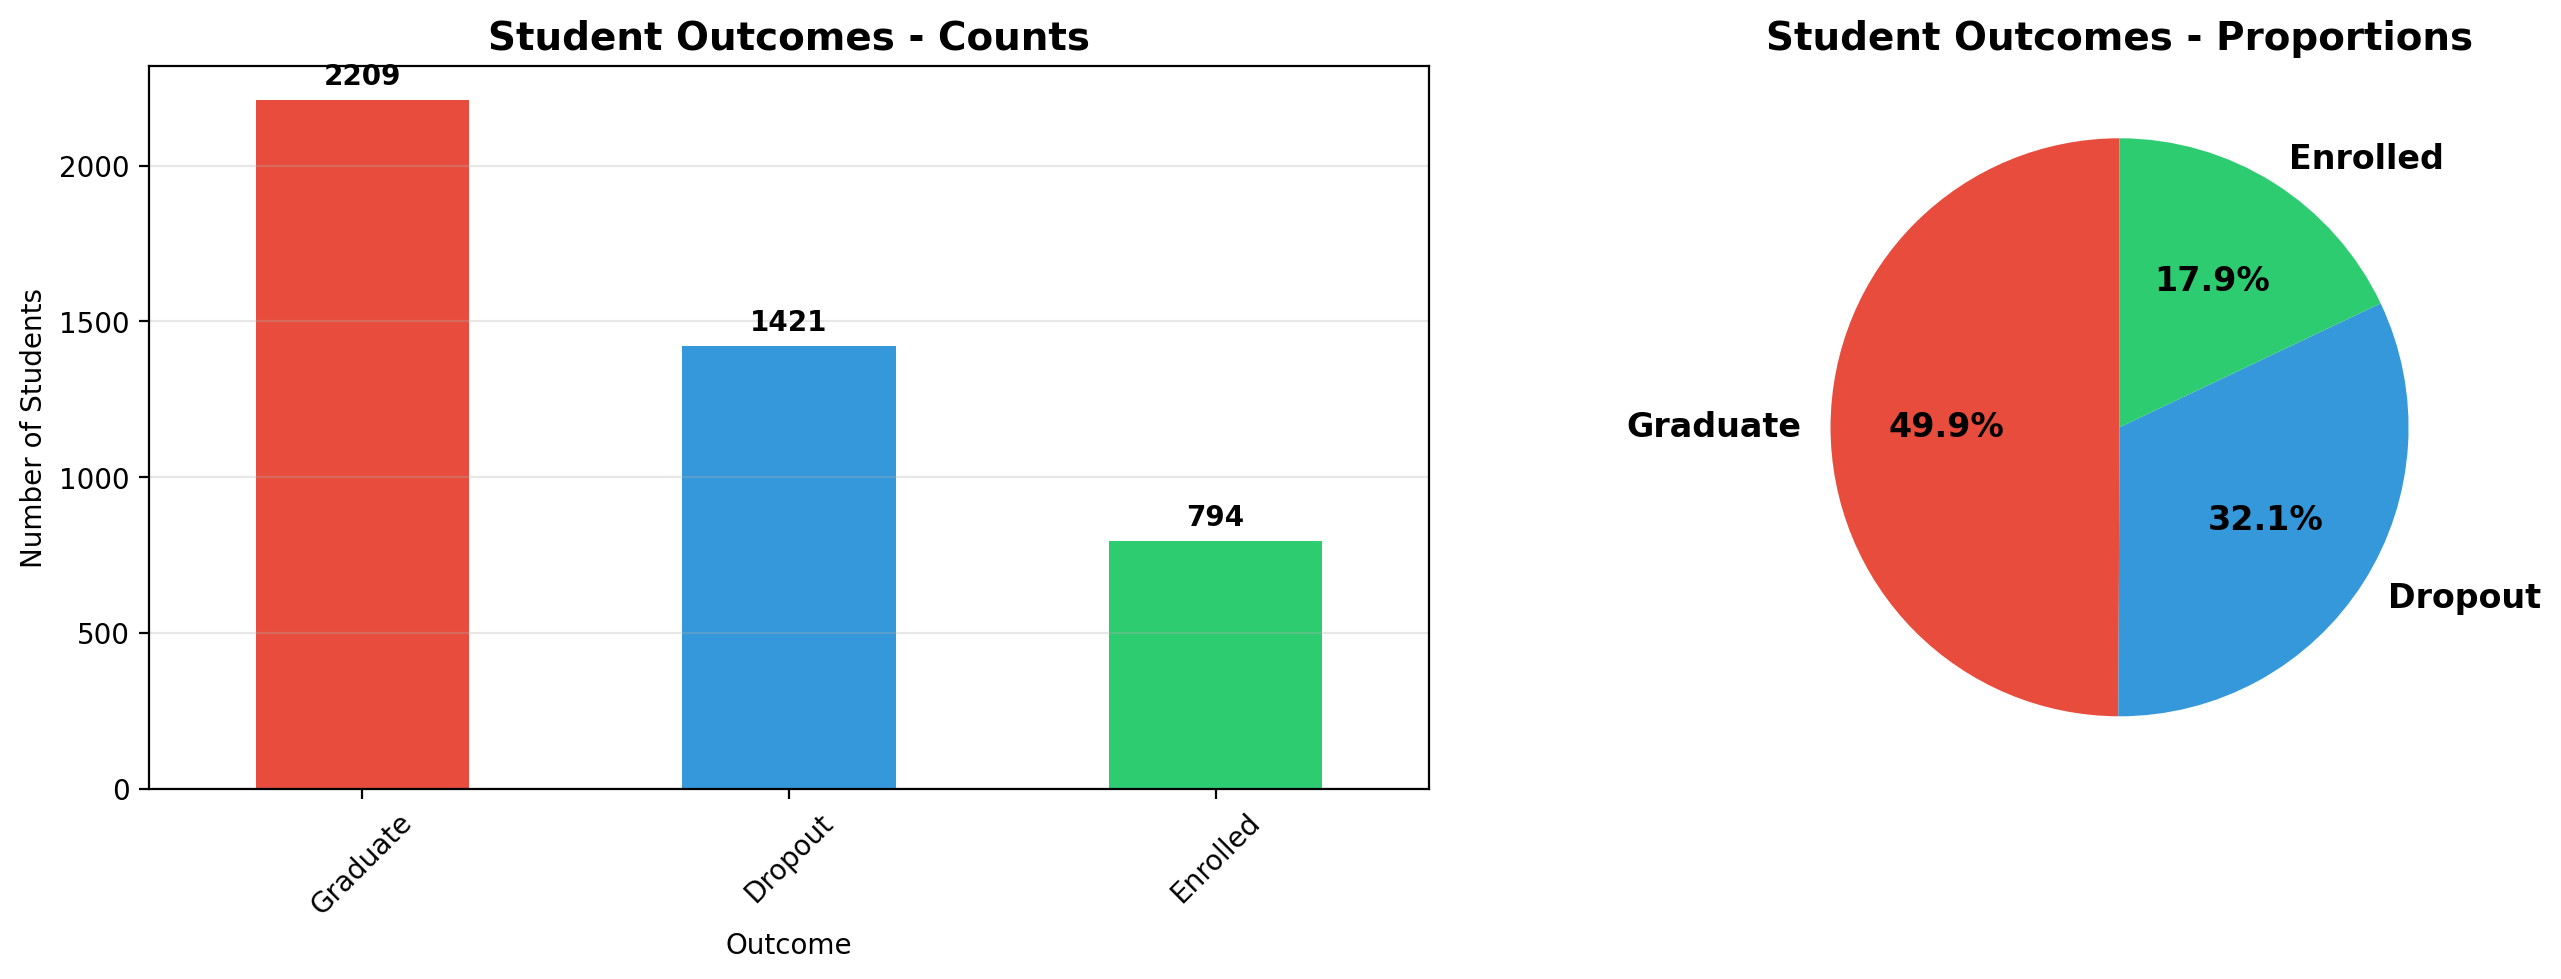

CLASS IMBALANCE DETECTED!
This is why we'll use PR-AUC instead of ROC-AUC for evaluation.


In [8]:
# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
target_counts.plot(kind='bar', ax=axes[0], color=['#e74c3c', '#3498db', '#2ecc71'])
axes[0].set_title('Student Outcomes - Counts', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Outcome')
axes[0].set_ylabel('Number of Students')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, v in enumerate(target_counts):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Pie chart
colors = ['#e74c3c', '#3498db', '#2ecc71']
axes[1].pie(target_counts, labels=target_counts.index, autopct='%1.1f%%',
            startangle=90, colors=colors, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Student Outcomes - Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("CLASS IMBALANCE DETECTED!")
print("This is why we'll use PR-AUC instead of ROC-AUC for evaluation.")

## 3. Feature Distributions

Examine key features that might predict dropout.

In [9]:
# Numeric feature summary
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features.remove(TARGET) if TARGET in numeric_features else None

print(f"Number of numeric features: {len(numeric_features)}")
df[numeric_features].describe()

Number of numeric features: 36


,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,18.669078,1.727848,8856.642631,0.890823,4.577758,132.613314,1.873192,19.561935,22.275316,...,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969
std,0.605747,17.484682,1.313793,2063.566416,0.311897,10.216592,13.188332,6.914514,15.603186,15.343108,...,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,...,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,...,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


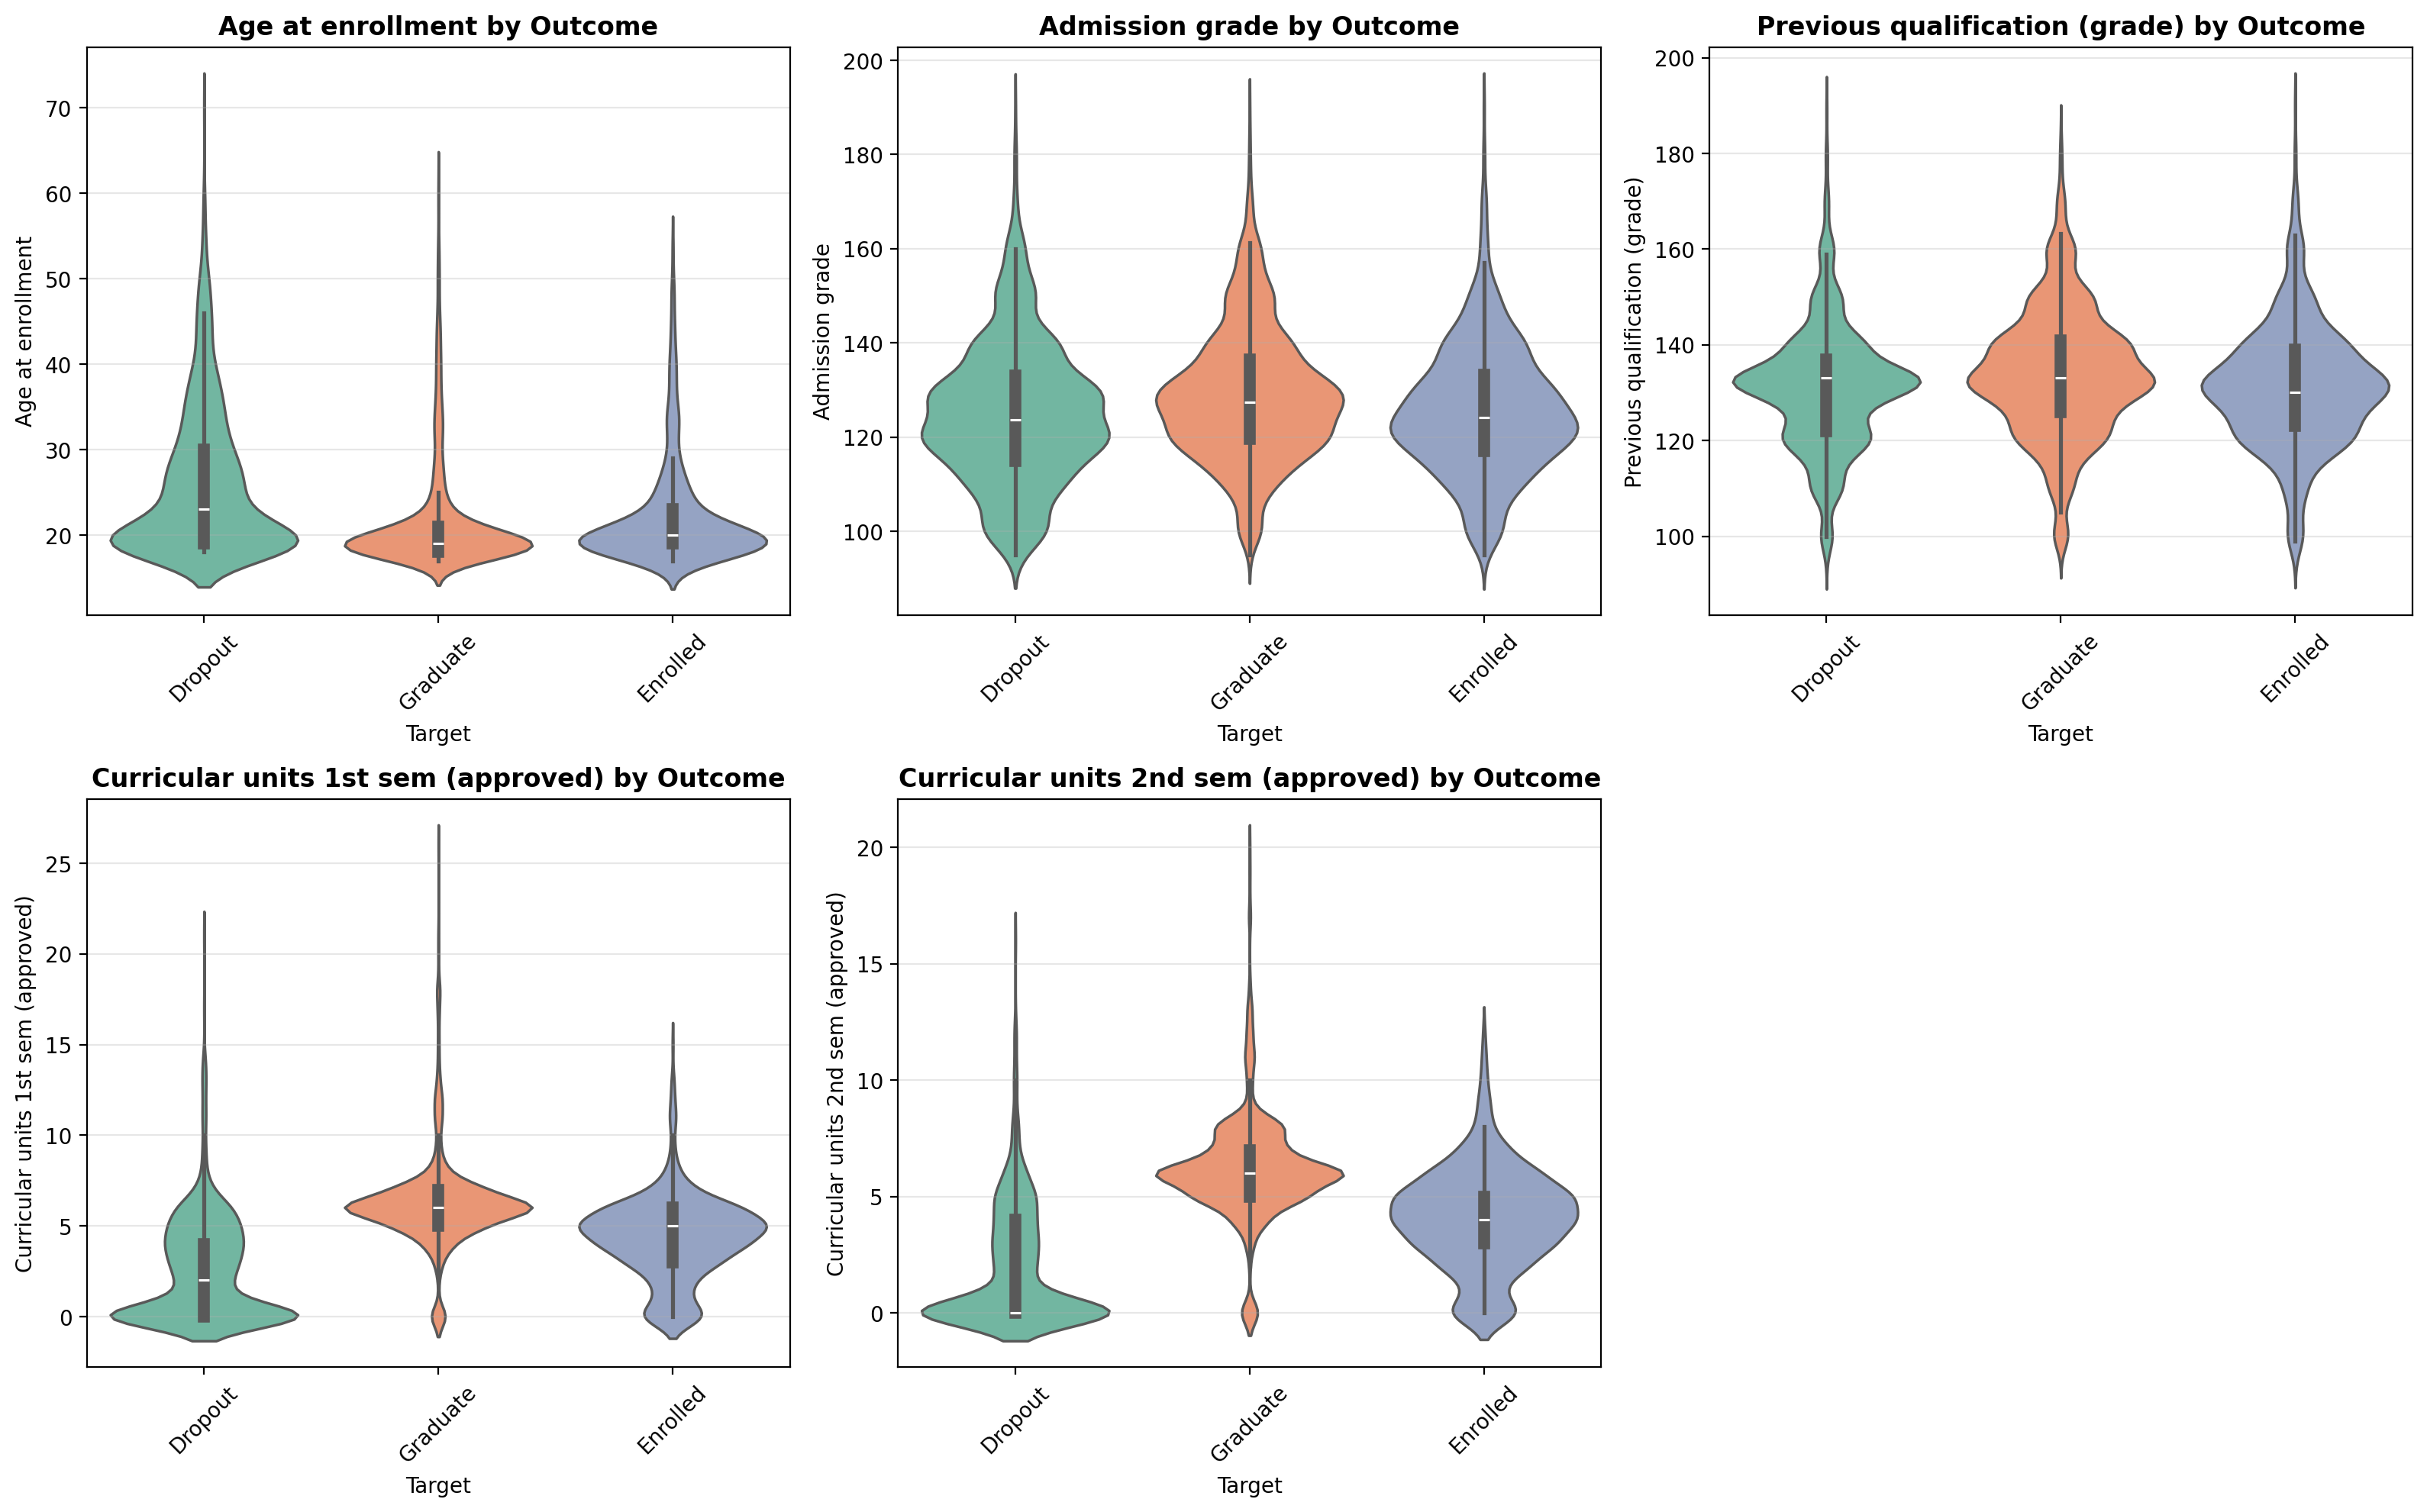

In [10]:
# Key features to examine
key_features = [
    'Age at enrollment',
    'Admission grade',
    'Previous qualification (grade)',
    'Curricular units 1st sem (approved)',
    'Curricular units 2nd sem (approved)'
]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, feature in enumerate(key_features):
    if feature in df.columns:
        # Violin plot by target
        # Need to encode target for numeric plotting
        df_plot = df.copy()
        target_map = {'Dropout': 0, 'Enrolled': 1, 'Graduate': 2}
        df_plot['Target_encoded'] = df_plot[TARGET].map(target_map)
        
        sns.violinplot(data=df_plot, x=TARGET, y=feature, ax=axes[idx], palette='Set2')
        axes[idx].set_title(f'{feature} by Outcome', fontweight='bold')
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(axis='y', alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

## 4. Correlation Analysis

Understanding feature relationships and identifying potential multicollinearity.

In [11]:
# Encode target for correlation
df_encoded = df.copy()
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_encoded[TARGET + '_encoded'] = le.fit_transform(df_encoded[TARGET])

# Select numeric features for correlation
numeric_cols = df_encoded.select_dtypes(include=['int64', 'float64']).columns.tolist()
corr_matrix = df_encoded[numeric_cols].corr()

print(f"Correlation matrix shape: {corr_matrix.shape}")

Correlation matrix shape: (37, 37)


In [17]:
# Correlation with target
target_corr = corr_matrix[TARGET + '_encoded'].drop(TARGET + '_encoded').sort_values(ascending=False)

print("\nTop 15 features correlated with Target:")
print("-"*60)
print(target_corr.head(15))

print("\n\nBottom 15 features correlated with Target:")
print("-"*60)
print(target_corr.tail(15))


Top 15 features correlated with Target:
------------------------------------------------------------
Curricular units 2nd sem (approved)       0.624157
Curricular units 2nd sem (grade)          0.566827
Curricular units 1st sem (approved)       0.529123
Curricular units 1st sem (grade)          0.485207
Tuition fees up to date                   0.409827
Scholarship holder                        0.297595
Curricular units 2nd sem (enrolled)       0.175847
Curricular units 1st sem (enrolled)       0.155974
Admission grade                           0.120889
Displaced                                 0.113986
Previous qualification (grade)            0.103764
Curricular units 2nd sem (evaluations)    0.092721
Application order                         0.089791
Daytime/evening attendance                0.075107
Curricular units 2nd sem (credited)       0.054004
Name: Target_encoded, dtype: float64


Bottom 15 features correlated with Target:
---------------------------------------------------

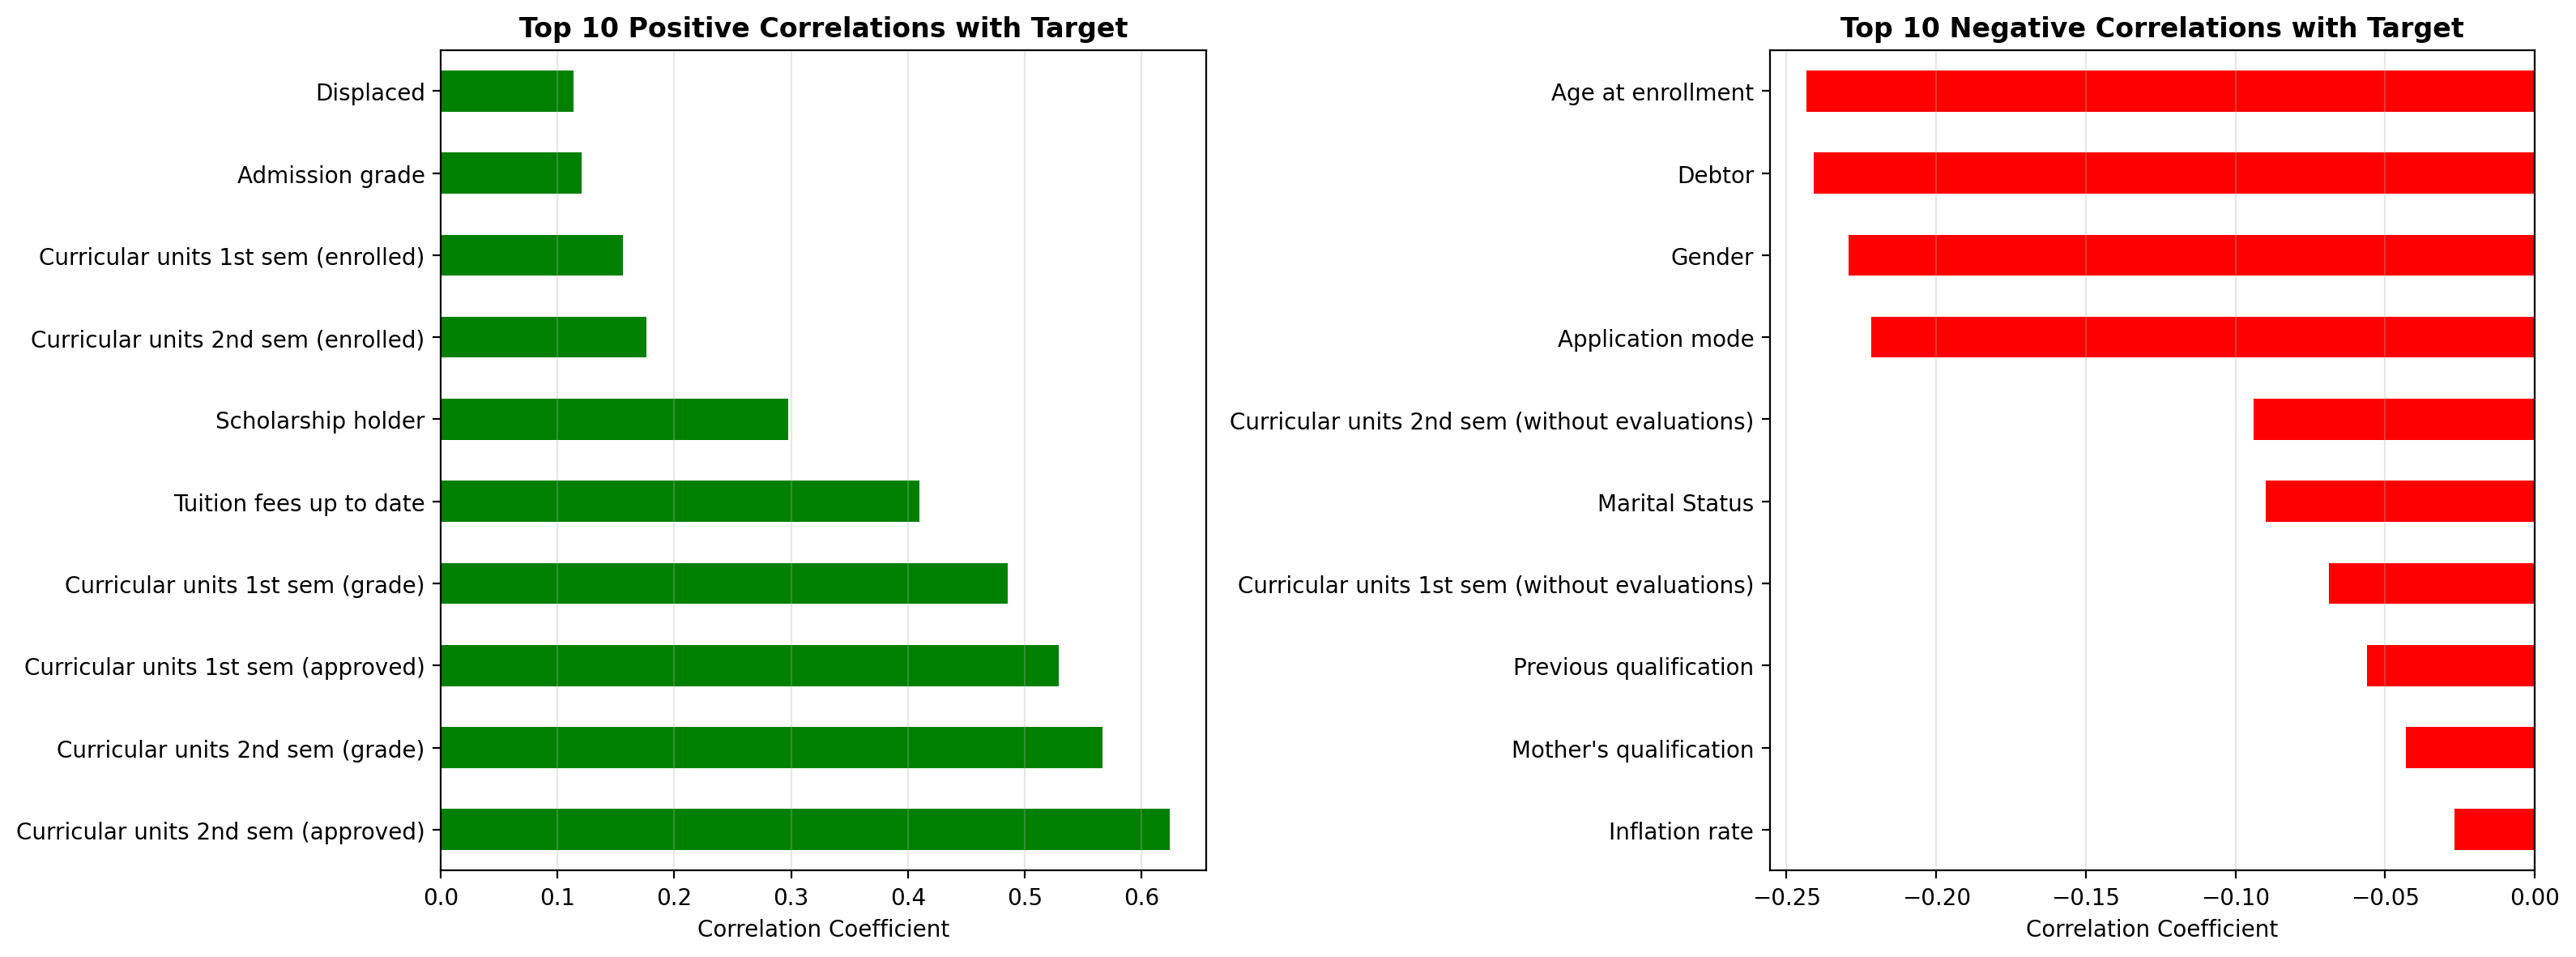

In [13]:
# Visualize top correlations with target
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top positive correlations
target_corr.head(10).plot(kind='barh', ax=axes[0], color='green')
axes[0].set_title('Top 10 Positive Correlations with Target', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Correlation Coefficient')
axes[0].grid(axis='x', alpha=0.3)

# Top negative correlations
target_corr.tail(10).plot(kind='barh', ax=axes[1], color='red')
axes[1].set_title('Top 10 Negative Correlations with Target', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Correlation Coefficient')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

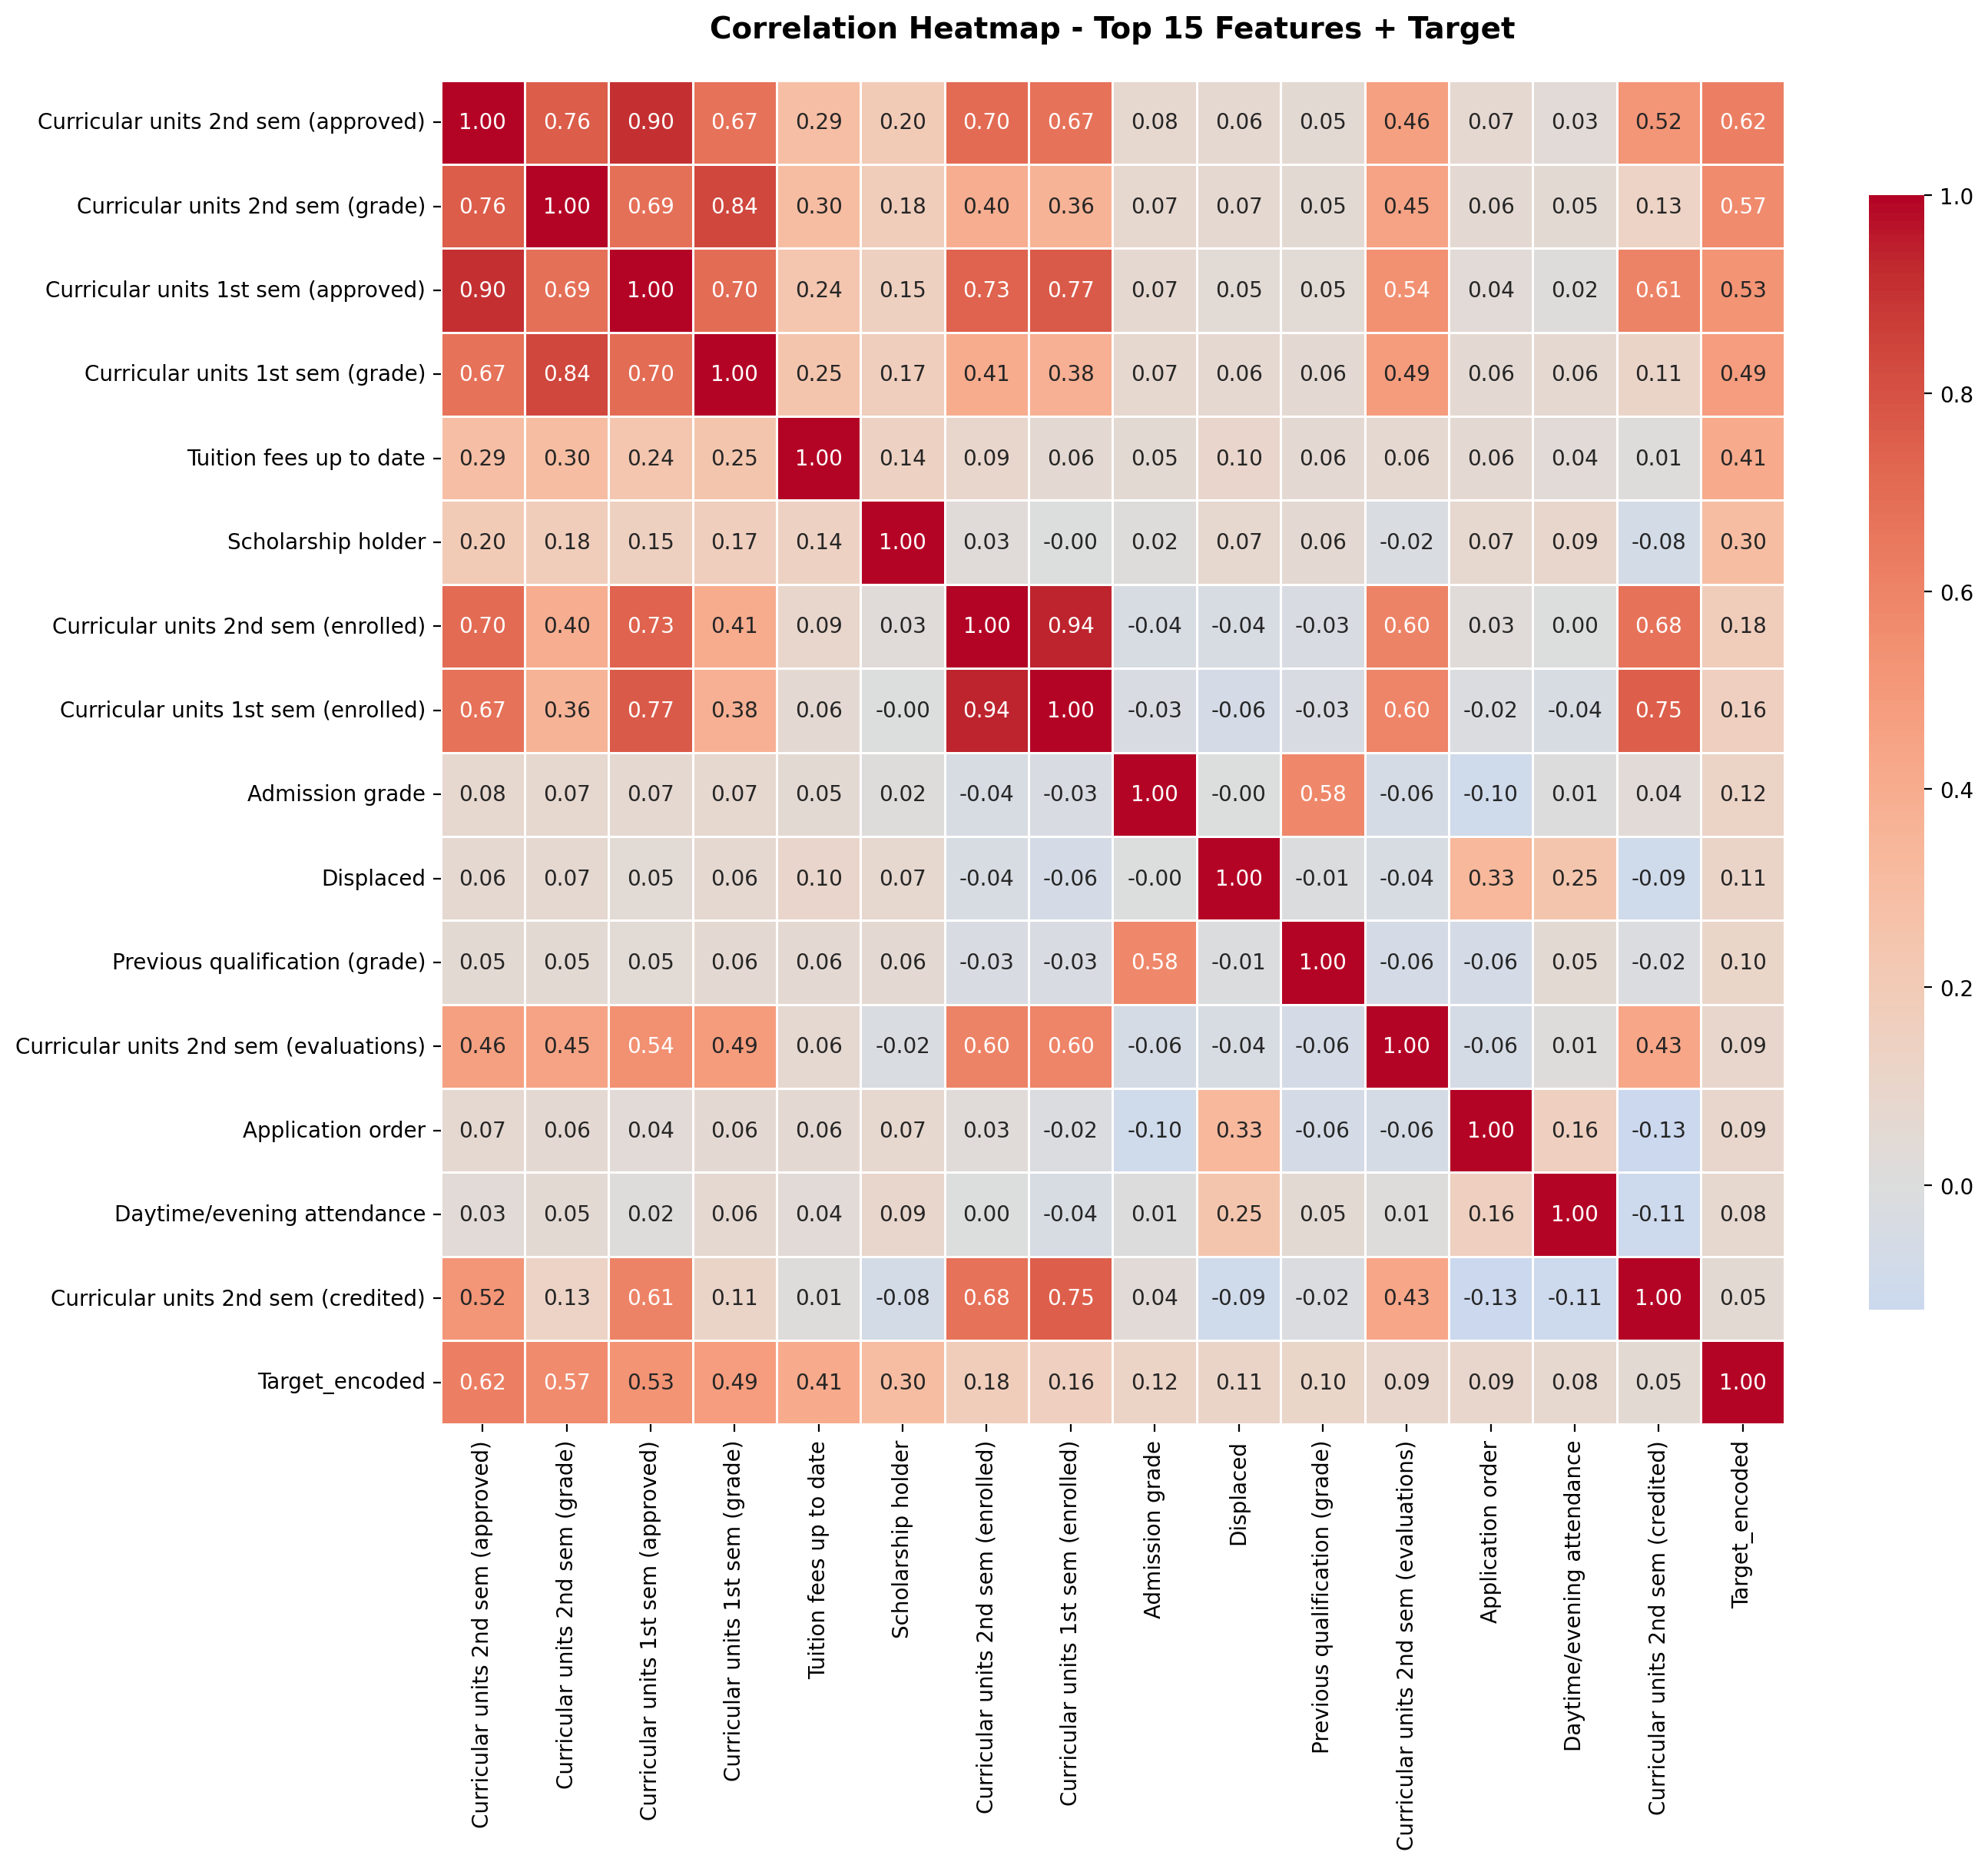

In [14]:
# Full correlation heatmap (sampled for readability)
# Select key features for visualization
important_features = target_corr.head(15).index.tolist() + [TARGET + '_encoded']

plt.figure(figsize=(14, 12))
sns.heatmap(
    df_encoded[important_features].corr(),
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8}
)
plt.title('Correlation Heatmap - Top 15 Features + Target', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 5. Temporal Feature Phases

This is the **most important** section for methodological soundness.

### The Problem: Temporal Leakage

If we use **Semester 2** performance to predict dropout at **enrollment**, the model will:
1. Look great in training (high accuracy!)
2. Be completely useless in production (that data doesn't exist yet)

### The Solution: Phased Modeling

We model at three time points:
- **Phase A (Enrollment)**: Only use data available at admission
- **Phase B (Semester 1)**: Add first semester performance
- **Phase C (Semester 2)**: Add second semester performance

Each phase answers a different question:
- **Enrollment**: Who should we watch from day 1?
- **Semester 1**: Who needs intervention after early struggles?
- **Semester 2**: Final risk assessment (may be too late)

In [18]:
# Display feature phases
print("TEMPORAL FEATURE PHASES")
print("-"*70)

for phase in ['enrollment', 'semester_1', 'semester_2']:
    desc = get_phase_description(phase)
    features = get_features_for_phase(phase)
    
    print(f"\n{desc['name'].upper()}")
    print(f"  Timing: {desc['timing']}")
    print(f"  Features: {desc['feature_count']}")
    print(f"  Use Case: {desc['use_case']}")
    print(f"  Intervention Window: {desc['intervention_window']}")

TEMPORAL FEATURE PHASES
----------------------------------------------------------------------

ENROLLMENT PHASE
  Timing: At admission (Time 0)
  Features: 24
  Use Case: Identify at-risk students before classes begin for proactive support
  Intervention Window: Maximum - Full academic year available

POST-SEMESTER 1 PHASE
  Timing: After first semester (Time 1)
  Features: 30
  Use Case: Refine risk assessment with early academic performance
  Intervention Window: Medium - Second semester available

POST-SEMESTER 2 PHASE
  Timing: After second semester (Time 2)
  Features: 36
  Use Case: Final risk assessment with full year of data
  Intervention Window: Limited - May be too late for some students


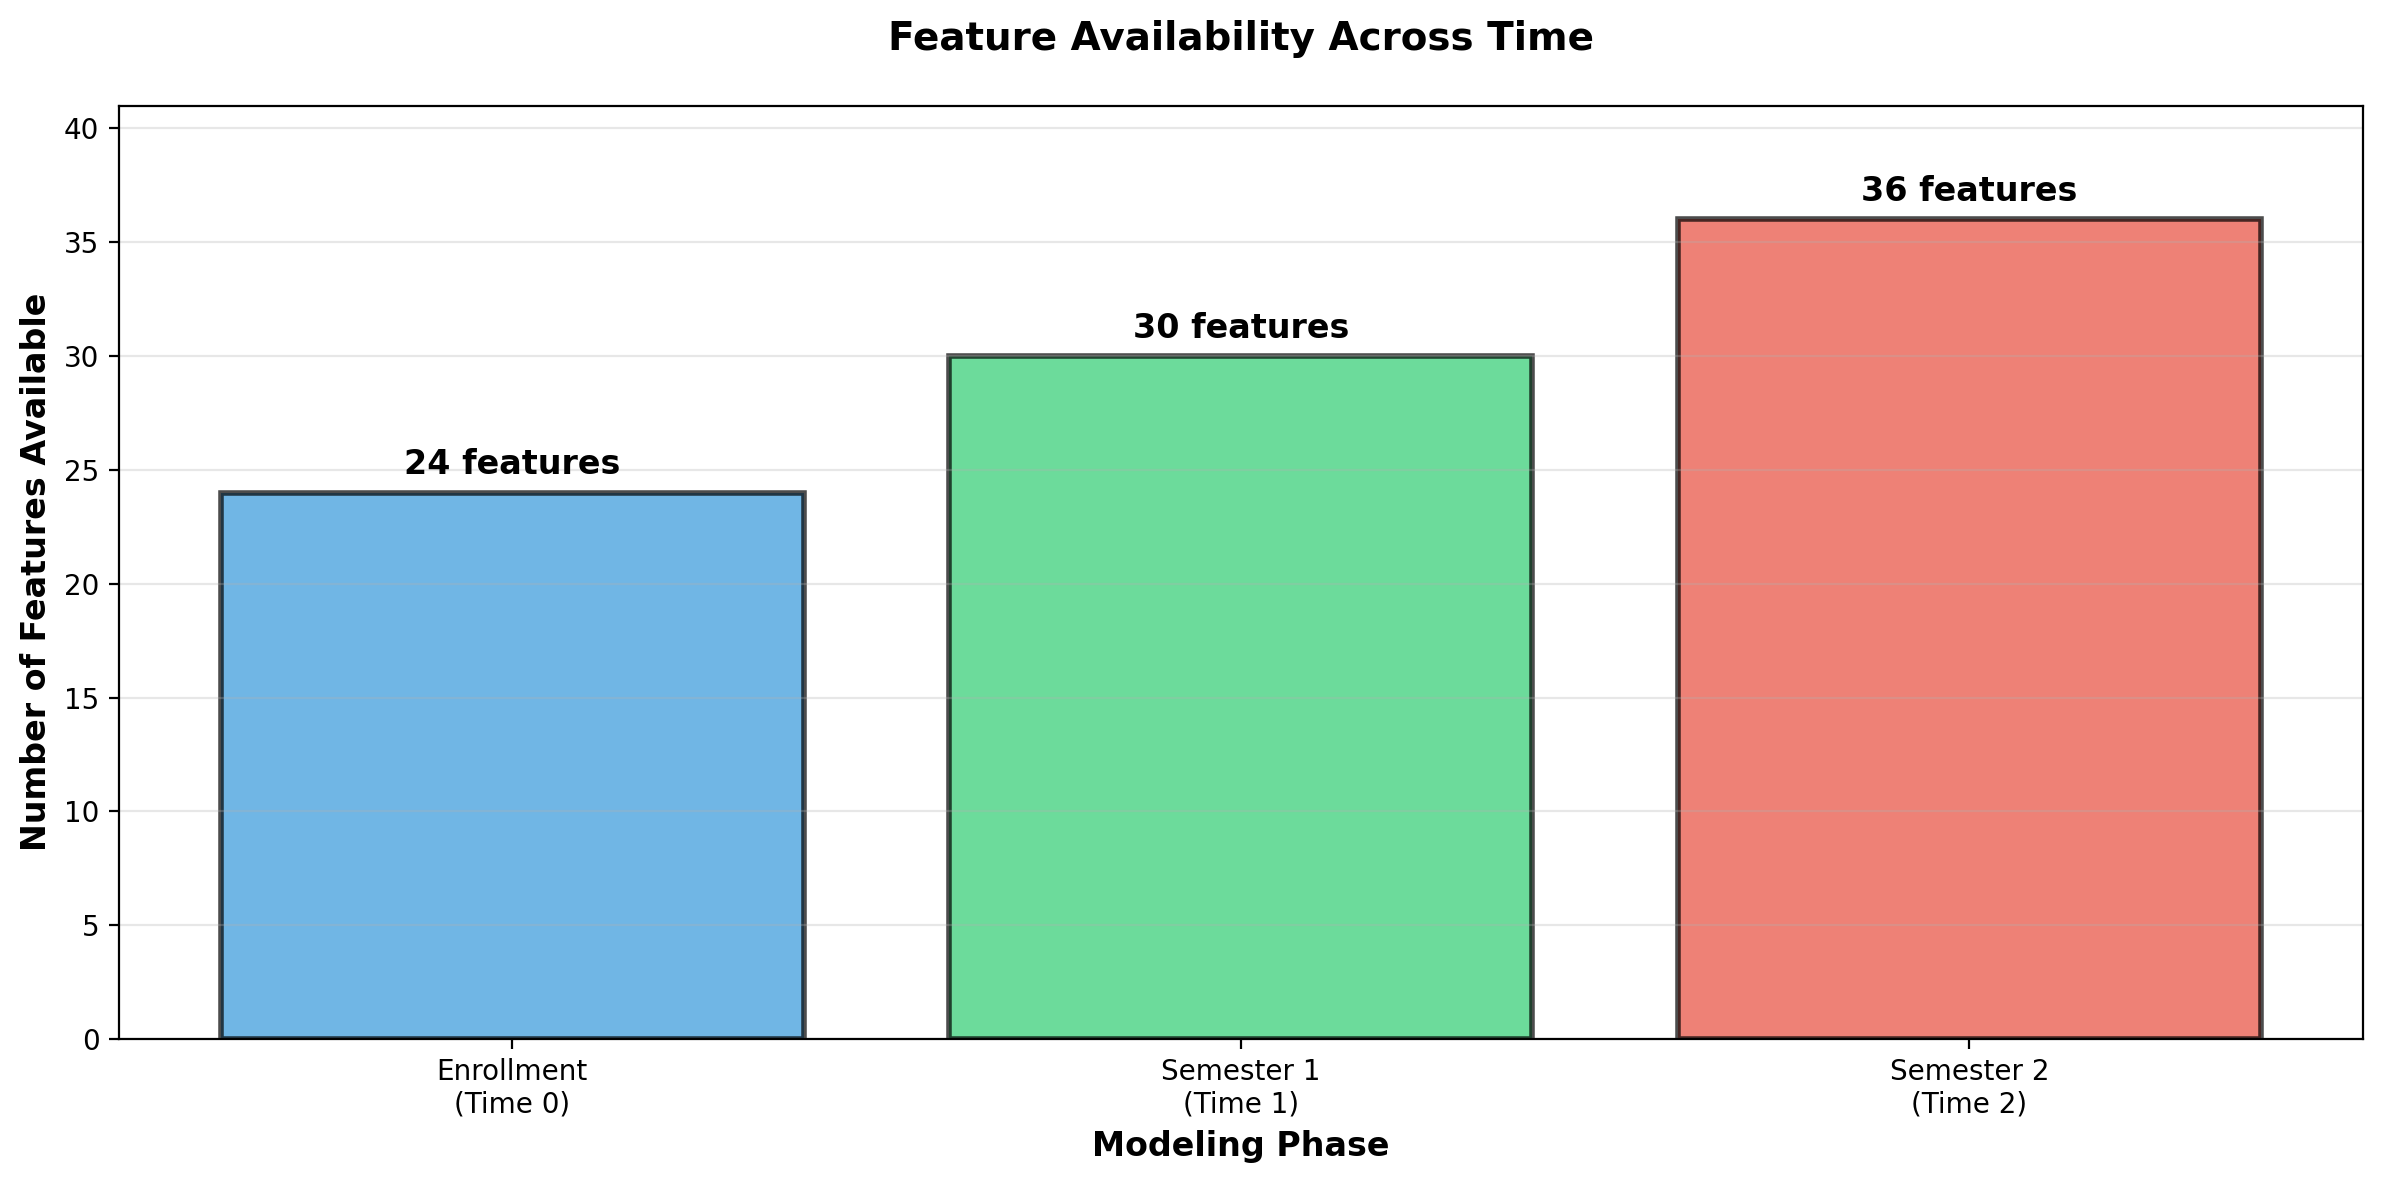

In [19]:
# Visualize feature phases
phases = ['Enrollment\n(Time 0)', 'Semester 1\n(Time 1)', 'Semester 2\n(Time 2)']
feature_counts = [
    len(ENROLLMENT_FEATURES),
    len(ENROLLMENT_FEATURES) + len(SEMESTER_1_FEATURES),
    len(ENROLLMENT_FEATURES) + len(SEMESTER_1_FEATURES) + len(SEMESTER_2_FEATURES)
]

fig, ax = plt.subplots(figsize=(12, 6))

colors = ['#3498db', '#2ecc71', '#e74c3c']
bars = ax.bar(phases, feature_counts, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

# Add value labels on bars
for bar, count in zip(bars, feature_counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{count} features',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Number of Features Available', fontsize=12, fontweight='bold')
ax.set_xlabel('Modeling Phase', fontsize=12, fontweight='bold')
ax.set_title('Feature Availability Across Time', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, max(feature_counts) + 5)

plt.tight_layout()
plt.show()

In [21]:
# Show feature breakdown
print("FEATURE BREAKDOWN BY PHASE")
print("-"*70)

print(f"\n ENROLLMENT FEATURES ({len(ENROLLMENT_FEATURES)} total):")
print("   Available at Time 0 (admission)")
for i, feat in enumerate(ENROLLMENT_FEATURES, 1):
    print(f"   {i:2d}. {feat}")

print(f"\n SEMESTER 1 FEATURES ({len(SEMESTER_1_FEATURES)} total):")
print("   Available at Time 1 (after 1st semester)")
for i, feat in enumerate(SEMESTER_1_FEATURES, 1):
    print(f"   {i:2d}. {feat}")

print(f"\n SEMESTER 2 FEATURES ({len(SEMESTER_2_FEATURES)} total):")
print("   Available at Time 2 (after 2nd semester)")
for i, feat in enumerate(SEMESTER_2_FEATURES, 1):
    print(f"   {i:2d}. {feat}")

FEATURE BREAKDOWN BY PHASE
----------------------------------------------------------------------

 ENROLLMENT FEATURES (24 total):
   Available at Time 0 (admission)
    1. Marital Status
    2. Nacionality
    3. Age at enrollment
    4. Gender
    5. International
    6. Application mode
    7. Application order
    8. Course
    9. Daytime/evening attendance
   10. Previous qualification
   11. Previous qualification (grade)
   12. Admission grade
   13. Mother's qualification
   14. Father's qualification
   15. Mother's occupation
   16. Father's occupation
   17. Displaced
   18. Educational special needs
   19. Debtor
   20. Tuition fees up to date
   21. Scholarship holder
   22. Unemployment rate
   23. Inflation rate
   24. GDP

 SEMESTER 1 FEATURES (6 total):
   Available at Time 1 (after 1st semester)
    1. Curricular units 1st sem (credited)
    2. Curricular units 1st sem (enrolled)
    3. Curricular units 1st sem (evaluations)
    4. Curricular units 1st sem (approved)

### Why This Matters: A Concrete Example

**❌ WRONG APPROACH:**
```python
# Using all features to predict at enrollment
X = df.drop('Target', axis=1)  # Includes semester 1 & 2 performance!
model.fit(X_train, y_train)
# High accuracy! But useless - we don't have semester grades at enrollment
```

**✅ CORRECT APPROACH:**
```python
# Phase A: Only enrollment features
enrollment_features = get_features_for_phase('enrollment')
X_enrollment = df[enrollment_features]
model_enrollment.fit(X_enrollment, y)
# This model can actually be used at admission time!
```

## 6. Missing Value Analysis

In [23]:
# Check for missing values
missing_counts = df.isnull().sum()
missing_pcts = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing %': missing_pcts
}).sort_values('Missing Count', ascending=False)

missing_df = missing_df[missing_df['Missing Count'] > 0]

if len(missing_df) > 0:
    print("Features with missing values:")
    print(missing_df)
else:
    print("No missing values detected in the dataset!")

No missing values detected in the dataset!


## Summary & Key Takeaways

### Dataset Overview
- **Samples**: 4,424 students
- **Features**: 36 features + 1 target
- **Target classes**: Dropout, Enrolled, Graduate
- **Class imbalance**: Present (will use PR-AUC)

### Feature Phases
- **Enrollment (26 features)**: Demographics, prior education, financial status
- **Semester 1 (+6 features)**: First semester academic performance
- **Semester 2 (+6 features)**: Second semester academic performance

### Key Insights
1. **Temporal leakage** is prevented by phased modeling
2. Semester performance features are **highly correlated** with dropout
3. Enrollment features provide **early warning signals**
4. Class imbalance requires **PR-AUC** instead of ROC-AUC

### Next Steps
In the next notebook, we'll:
1. Train models for each phase
2. Compare performance across phases
3. Evaluate using **PR-AUC** and **Recall@K**
4. Identify the best model for deployment